# Lecture 9: FunSearch — Program Search with LLMs


In this seminar we explore **FunSearch**, a framework for mathematical discovery through program synthesis guided by large language models (LLMs), as introduced in [Romera-Paredes et al., *Nature* (2023)](https://www.nature.com/articles/s41586-023-06924-6).


### Core Idea

We set up an **LLM-based program search loop** to:

- Prompt an LLM to generate candidate programs.
- **Automatically** evaluate those programs.
- Iterate via an evolutionary process to improve solutions over time.



## 1.1 **Setting up**
### Platform: _Nebius AI Studio_

Supports open-source models like **LLaMA**, **Mistral**, **Qwen**, and **Gemma**.

- **Get an API key:** [studio.nebius.ai/settings/api-keys](https://studio.nebius.ai/settings/api-keys)  
- Save it at: `/MyDrive/API_keys/nebius_api_key` (no file extension)

---

### Optional: Try the Playground

Explore prompts interactively at  
[studio.nebius.ai/playground](https://studio.nebius.ai/playground)

In [ ]:
# === Colab Setup for Nebius + OpenAI-compatible client ===
# 1) Install deps
%pip install -q --upgrade openai tiktoken

# 2) Imports & deterministic seeding
import ast, os, sys, json, random, re, tiktoken

import numpy as np
from abc import abstractmethod
from google.colab import drive
from openai import OpenAI

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 3) Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 4) Load Nebius API key from Drive (file with no extension)
KEY_PATH = "/content/drive/MyDrive/API_keys/nebius_api_key"
if not os.path.exists(KEY_PATH):
    raise FileNotFoundError(
        f"API key file not found at {KEY_PATH}. "
        "Create the file with your Nebius API key (single line, no quotes)."
    )

with open(KEY_PATH, "r") as f:
    NEBIUS_API_KEY = f.read().strip()

if not NEBIUS_API_KEY or len(NEBIUS_API_KEY) < 10:
    raise ValueError("Nebius API key seems empty or malformed.")

# 5) Optional: expose in env
os.environ["NEBIUS_API_KEY"] = NEBIUS_API_KEY

# 6) Initialize OpenAI-compatible client for Nebius
NEBIUS_BASE_URL = os.environ.get("NEBIUS_BASE_URL", "https://api.studio.nebius.ai/v1/")
client = OpenAI(api_key=NEBIUS_API_KEY, base_url=NEBIUS_BASE_URL)

# 7) Smoke check (no network request)
print("Nebius client configured.")
print("Base URL:", NEBIUS_BASE_URL)
print("API key loaded (last 4 chars):", NEBIUS_API_KEY[-4:])

Mounted at /content/drive
Nebius client configured.
Base URL: https://api.studio.nebius.ai/v1/
API key loaded (last 4 chars): L2jA


## 1.2. Nebius API

We now demonstrate how to interact with `Meta-Llama-3.1-70B-Instruct` via the **Nebius API**.

In this setting:

- The text **sent to the model** is called a **prompt**.
- The model's **response** is referred to as a **completion**.

Using the `openai` Python library (which Nebius supports), we send not just a plain string, but a **list of messages**, each with a role:

- `"system"` — provides instructions or constraints for the assistant's behavior (e.g., tone, persona, or scope).
- `"user"` — represents your input (the task or question).
- `"assistant"` — can include prior responses or hints to guide generation.

### Important parameters:

- `max_tokens`: sets a **hard limit** on the number of tokens in the generated response.  
  Note: This is not the same as asking "Answer in 200 tokens"—it’s a cap, not a directive.
- `temperature`: controls **randomness** (0 = deterministic; higher = more creative).
- `top_p`: sets a **nucleus sampling** threshold—another way to control diversity.

In [ ]:
# Initialize client
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Choose model (see available models: https://docs.nebius.com/studio/inference/models/)
MODEL = "meta-llama/Meta-Llama-3.1-70B-Instruct"

# Create completion
completion = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software engineer and mathematician."
        },
        {
            "role": "user",
            "content": """Hi! Who are you?"""
        },
    ],
    temperature=0.6,
    max_tokens=200,
    top_p=0.9,
)

# Print response
print(completion.to_json())

{
  "id": "chatcmpl-f0636b2e47d74ef090b1b64e77f634b9",
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Nice to meet you! I'm a software engineer and mathematician with a passion for solving complex problems and building innovative solutions. I have a strong background in computer science, mathematics, and software development, with expertise in areas such as algorithms, data structures, machine learning, and software design patterns.\n\nI've worked on a wide range of projects, from developing scalable web applications and mobile apps to building predictive models and data analytics pipelines. I'm also familiar with various programming languages, including Python, Java, C++, and JavaScript, as well as frameworks and libraries such as TensorFlow, PyTorch, and React.\n\nMathematically, I'm well-versed in areas like linear algebra, calculus, probability, and statistics, which I often apply to solve probl

The `completion` variable contains much information; to extract only the completion, use:

In [ ]:
print(completion.choices[0].message.content)


Nice to meet you! I'm a software engineer and mathematician with a passion for solving complex problems and building innovative solutions. I have a strong background in computer science, mathematics, and software development, with expertise in areas such as algorithms, data structures, machine learning, and software design patterns.

I've worked on a wide range of projects, from developing scalable web applications and mobile apps to building predictive models and data analytics pipelines. I'm also familiar with various programming languages, including Python, Java, C++, and JavaScript, as well as frameworks and libraries such as TensorFlow, PyTorch, and React.

Mathematically, I'm well-versed in areas like linear algebra, calculus, probability, and statistics, which I often apply to solve problems in machine learning, optimization, and data analysis. I'm always excited to dive into new challenges and explore the intersection of math and software engineering.

What brings you here toda

When using LLM APIs, the main unit of billing is the number of **tokens** processed.  
Every API call involves two types of tokens:

- **Input tokens** — the tokens in your prompt (including system, user, and assistant messages passed to the model).  
- **Output tokens** — the tokens generated by the model as its completion.

The total cost of a request depends on the sum of input and output tokens.  
For up-to-date pricing details, see the [Nebius AI Studio model reference](https://studio.nebius.com/).

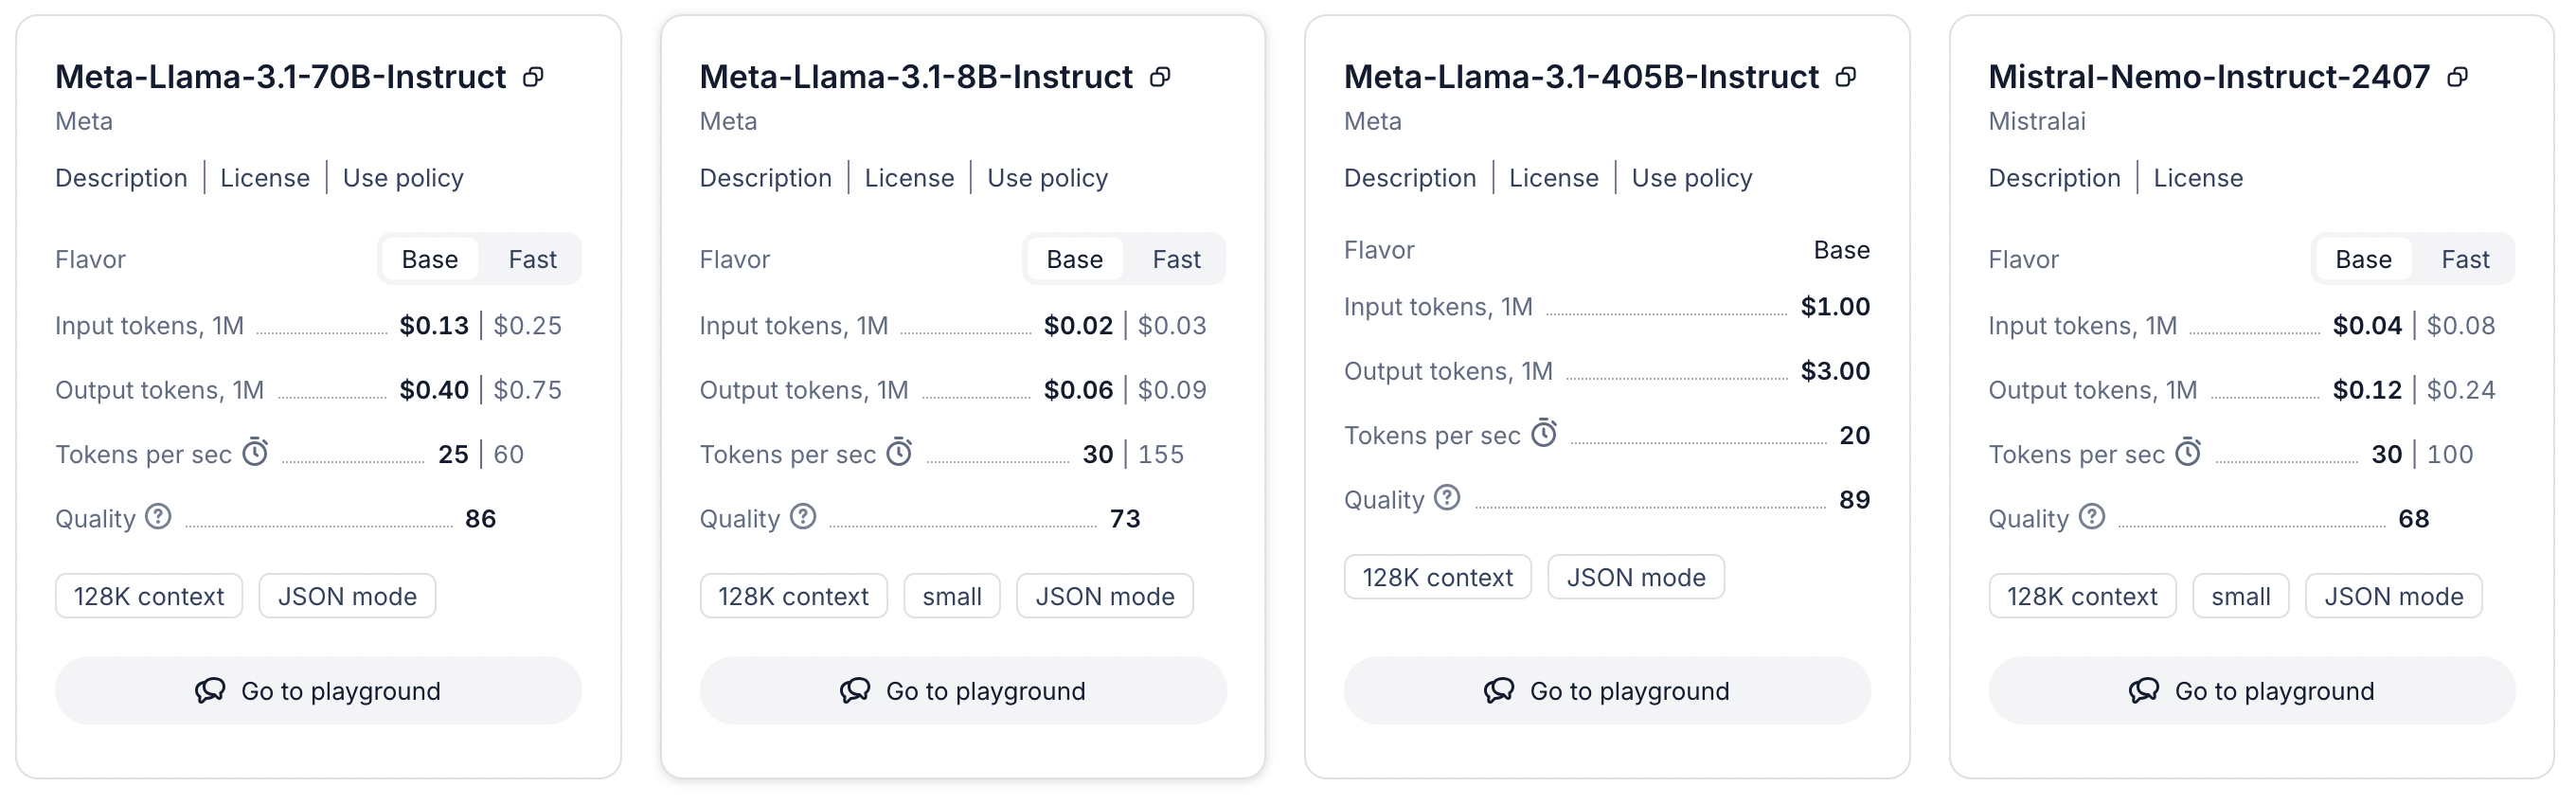

If you want to continue the discussion, you can just augment the `messages` variable:

```
messages=[
        {
            "role": "system",
            "content": <system prompt>
        },
        {
            "role": "user",
            "content": <user's first line>
        },
        {
            "role": "assistant"
            "content": <LLM's answer>
        },
        {
            "role": "user"
            "content": <user's second line>
        }
    ]
```
Each entry in `messages` is called a **message block**, and it has two fields:  
- **role** – describes who is “speaking” (`system`, `user`, or `assistant`).  
- **content** – the actual text of the message.  

The conversation is built as a sequence of these blocks, and the model uses the entire list to generate the next response.  

### Important notes on usage
- **If you do not provide any messages**: the API call will fail, because at least one message (usually a `user` message) must be provided.  
- **If you provide multiple user prompts**: the model treats them as separate turns in the same conversation, processed in the order they appear in the list. The assistant generates a reply to the *last* user message, taking the earlier ones into account as context.  
- **If you call the API twice without re-sending the conversation history**: the model will *not* remember the previous call. The API is stateless — it does not persist conversations between requests. If you want continuity, you must resend the entire conversation history (all relevant message blocks) each time.  

Also each LLM has **max context length**, which is the maximal sum of lengths of all messages the LLM is going to process. For GPT-4o-mini it's 128k tokens. After max context length, the first messages will be ignored.

A short reference for you about the lengths of various data (with the tokenizer of Llama-3-8B; see details below).

| Text  | n_okens  |
|----------|----------|
| [Text2text\_generation.py from Transformers](https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/text2text_generation.py)   | 3.5k   |
| [xLSTM paper .tex file](https://arxiv.org/abs/2405.04517)    | 39k  |
| Harry Potter and the Philosopher's Stone | 109K |
| [UK Energy Act 2023](https://www.legislation.gov.uk/ukpga/2023/52/contents)   | 248k   |
| Lord of the Rings | 500K |
| Langchain github repo | 5.2M |
| Pytorch github repo | 28M |

## 1.3 Tokenization

LLMs may have some problems with math. There is a reason for that. Before going into the LLM, the prompt is **tokenized**, that is, split into **tokens**. And the completion is also generated **token by token**.

<center>
<img src="https://drive.google.com/uc?export=view&id=1nKMwN3nZ9ZoEQcdzhxmv5QPXLHv6K7MK" width=600 />
</center>

As you see, the words are cut into pieces called **subword units**. Why? This allows to:

- Have a dictionary (list of all tokens) of fixes size. This wouldn't work with **word-level** tokeinization: typos and neologisms would make the dictionary too huge.
- Have meaningful tokens, unlike in **character-level** tokenization.

**Note**. Some LLMs use hybrid strategy, where `import pandas as pd` may be one token.

Let's try the OpenAI tokenizer. For that, we need the `tiktoken` library.

In [ ]:
encoding = tiktoken.encoding_for_model('gpt-4o-mini')

Now, let's tokenize a simple prompt.

In [ ]:
initial_string = 'Given a positive integer n, find the largest subset A of {1,2,…,n} such that for any distinct a,b in A, neither a divides b nor b divides a.'

# Tokenization
encoding = tiktoken.encoding_for_model("gpt-4o")
encoded_string = encoding.encode(initial_string)
print('After tokenization (encoded string): ', encoded_string)

# Tokenization
print('Decoding back: ', encoding.decode(encoded_string))

# Decoding each token:
for token in encoded_string:
    print(f'{token}: {encoding.decode([token])}')

After tokenization (encoded string):  [39520, 261, 8841, 16336, 297, 11, 1646, 290, 10574, 58845, 355, 328, 354, 16, 11, 17, 69302, 11, 77, 92, 2238, 484, 395, 1062, 16913, 261, 17568, 306, 355, 11, 26349, 261, 144028, 287, 11777, 287, 144028, 261, 13]
Decoding back:  Given a positive integer n, find the largest subset A of {1,2,…,n} such that for any distinct a,b in A, neither a divides b nor b divides a.
39520: Given
261:  a
8841:  positive
16336:  integer
297:  n
11: ,
1646:  find
290:  the
10574:  largest
58845:  subset
355:  A
328:  of
354:  {
16: 1
11: ,
17: 2
69302: ,…
11: ,
77: n
92: }
2238:  such
484:  that
395:  for
1062:  any
16913:  distinct
261:  a
17568: ,b
306:  in
355:  A
11: ,
26349:  neither
261:  a
144028:  divides
287:  b
11777:  nor
287:  b
144028:  divides
261:  a
13: .


### 1.3.1 Tokenization consequences


LLMs don't naturally see the text on a character level, and it is one of the reasons why LLMs are not so good at arithmetics, reversing strings and similar tasks. Let's look at an example.

In [ ]:
initial_string = '1234567890'

# Tokenization
encoded_string = encoding.encode(initial_string)
print('After tokenization (encoded string): ', encoded_string)

# Decoding each token:
for token in encoded_string:
    print(f'{token}: {encoding.decode([token])}')

After tokenization (encoded string):  [7633, 19354, 29338, 15]
7633: 123
19354: 456
29338: 789
15: 0


## 1.4 Example


In this example, we present a classical combinatorial problem:  

**Problem:**  

Given a positive integer $n$, find the largest subset $A \subseteq \{1,2,\dots,n\}$ such that for any two distinct elements $a, b \in A$, neither divides the other.  

In other words, $A$ must form a maximum-size **antichain** under divisibility.

This is a non-trivial optimization problem: a simple greedy approach can generate a valid set, but it may not always produce the largest possible one. Our goal here is not only to solve the problem, but to explore how a Large Language Model (LLM) can propose **new algorithmic ideas**.  

By providing the LLM with a description of the problem and a baseline (suboptimal) solution, we invite it to generate improved strategies that aim for the true maximum. This demonstrates how LLMs can act as creative collaborators in mathematics and computer science — suggesting alternative approaches, algorithms, or even insights into the structure of the problem.  

In [ ]:
# Initialize client
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Choose model (see available models: https://docs.nebius.com/studio/inference/models/)
MODEL = "meta-llama/Meta-Llama-3.1-70B-Instruct"

# Create completion
completion = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software engineer and mathematician."
        },
        {
            "role": "user",
            "content": """You are given the following problem:

Problem: Given a positive integer n, find the largest subset A of {1, 2, …, n}
          such that for any distinct a, b in A, neither a divides b nor b
          divides a.
In other words, A must form a maximum-size antichain under divisibility.

Below is an example of a solution:

def greedy_divisibility_antichain(n):
    if n <= 0:
        return []
    A = []
    for x in range(1, n):
        ok = True
        for a in A:
            if x % a == 0 or a % x == 0:
                ok = False
                break
        if ok:
            A.append(x)
    return A

Task: Suggest and implement in Python a more optimal and efficient algorithm that always
constructs a subset of maximum possible size. Return only Python code, without
any additional content.
"""
        },
    ],
    temperature=0.6,
    max_tokens=200,
    top_p=0.9,
)

# Print response
print(completion.choices[0].message.content)

```python
def optimal_divisibility_antichain(n):
    A = []
    for x in range(n, 0, -1):
        if all(x % a != 0 for a in A):
            A.append(x)
    return A[::-1]
```


## 1.5. Advanced Prompting Techniques



Trying to make a good prompt is an iterative trial and error process. For some general advices see e.g. [https://platform.openai.com/docs/guides/prompt-engineering](https://platform.openai.com/docs/guides/prompt-engineering) Common advices include:

0. Write in English (in case it is not your native language).
1. Be Specific and Clear.
2. Break Down Complex Tasks.
3. Ask the model to adopt a persona.
4. Use delimiters to clearly indicate distinct parts of the input.
5. Provide examples.
6. Specify the format and desired length of the output.

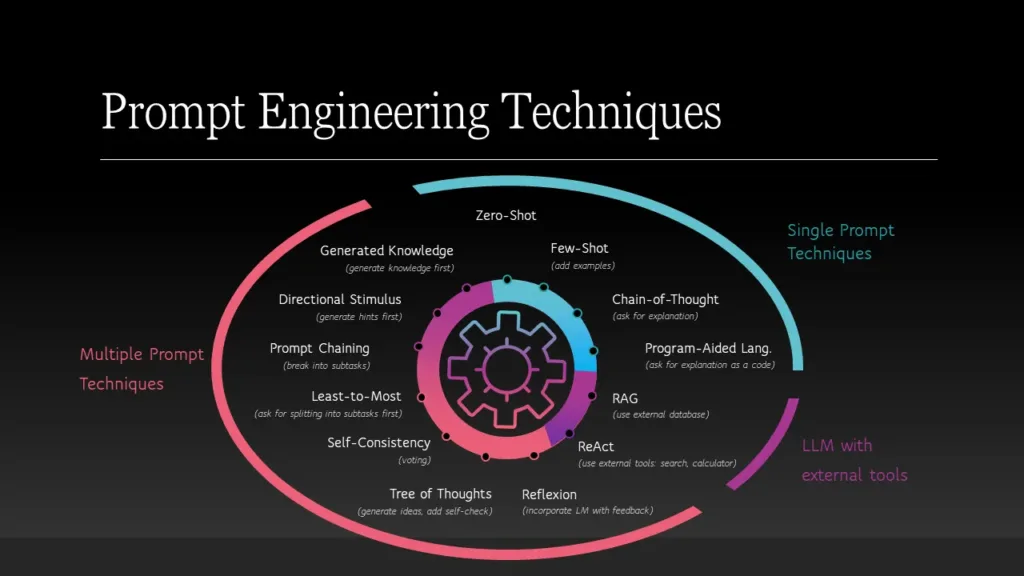

As a "rule of thumb", when struggling with prompts, structure them like a dictionary:

```
Q1: Question-1.
A1: Answer-1.
S1: Solution-1.
Q2: Question-2.
etc.
```



### 1.5.1 Generate multiple answers


Let's briefly discuss several techniques (indirectly) used in FunSearch.

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Which LLM to use
# For more models, see https://docs.nebius.com/studio/inference/models/
MODEL = "meta-llama/Meta-Llama-3.1-70B-Instruct"


1. Try leveraging LLM hallucinations by **generating multiple answers**.

In [ ]:
completion = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software engineer and mathematician."
        },
        {
            "role": "user",
            "content": """Generate 2 different Python functions that use different logics to solve a problem:
  Given a positive integer n, find the largest subset A of {1,2,…,n} such that for any distinct a,b in A, neither a divides b nor b divides a.



                          Example:
                          Input: 10
                          Output: [...]

                          Function 1:
                  Output python code for two functions and nothing else
                          """
        },
    ],
    temperature=0.6,
    max_tokens=512,
    top_p=0.9
)

print(completion.choices[0].message.content)

**Function 1: Greedy Approach**
```python
def largest_subset_greedy(n):
    """
    Find the largest subset A of {1,2,…,n} such that for any distinct a,b in A,
    neither a divides b nor b divides a.

    :param n: Positive integer
    :return: Largest subset A
    """
    subset = []
    for i in range(n, 0, -1):
        if all(i % j != 0 and j % i != 0 for j in subset):
            subset.append(i)
    return subset
```

**Function 2: Dynamic Programming Approach**
```python
def largest_subset_dp(n):
    """
    Find the largest subset A of {1,2,…,n} such that for any distinct a,b in A,
    neither a divides b nor b divides a.

    :param n: Positive integer
    :return: Largest subset A
    """
    dp = [[] for _ in range(n + 1)]
    for i in range(1, n + 1):
        for j in range(i, 0, -1):
            if all(j % k != 0 and k % j != 0 for k in dp[i - 1]):
                dp[i] = dp[i - 1] + [j]
                break
    return dp[n]
```


### 1.5.2 Few-shot learning

2. **Few-shot learning** = provide a small number of in-context examples.

The model uses these examples to understand the pattern or task and then applies it to new, unseen inputs. This reduces the need for large, labeled datasets and enables rapid adaptation to novel tasks or domains, effectively transferring learned knowledge to new situations.

In [ ]:
completion = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software engineer."
        },
        {
            "role": "user",
            "content": """
                    Calculate the result of the following math problems.

                    Example 1:
                    Question: func(3,5)
                    Answer: 243

                    Example 2:
                    Question: func(10,4)
                    Answer: 10000

                    Question: func(7, 3)
                    Answer:
                          """
        },
    ],
    temperature=0.6,
    max_tokens=200,
    top_p=0.9
)

print(completion.choices[0].message.content)

Based on the examples, I notice that the function `func` seems to be raising the first argument to the power of the second argument.

If that's correct, then:

`func(7, 3)` would be equivalent to `7^3`

Which is equal to: `343`

So, the answer is: `343`


# 2. FunSearch


The FunSearch scheme is illustrated in the figures below.


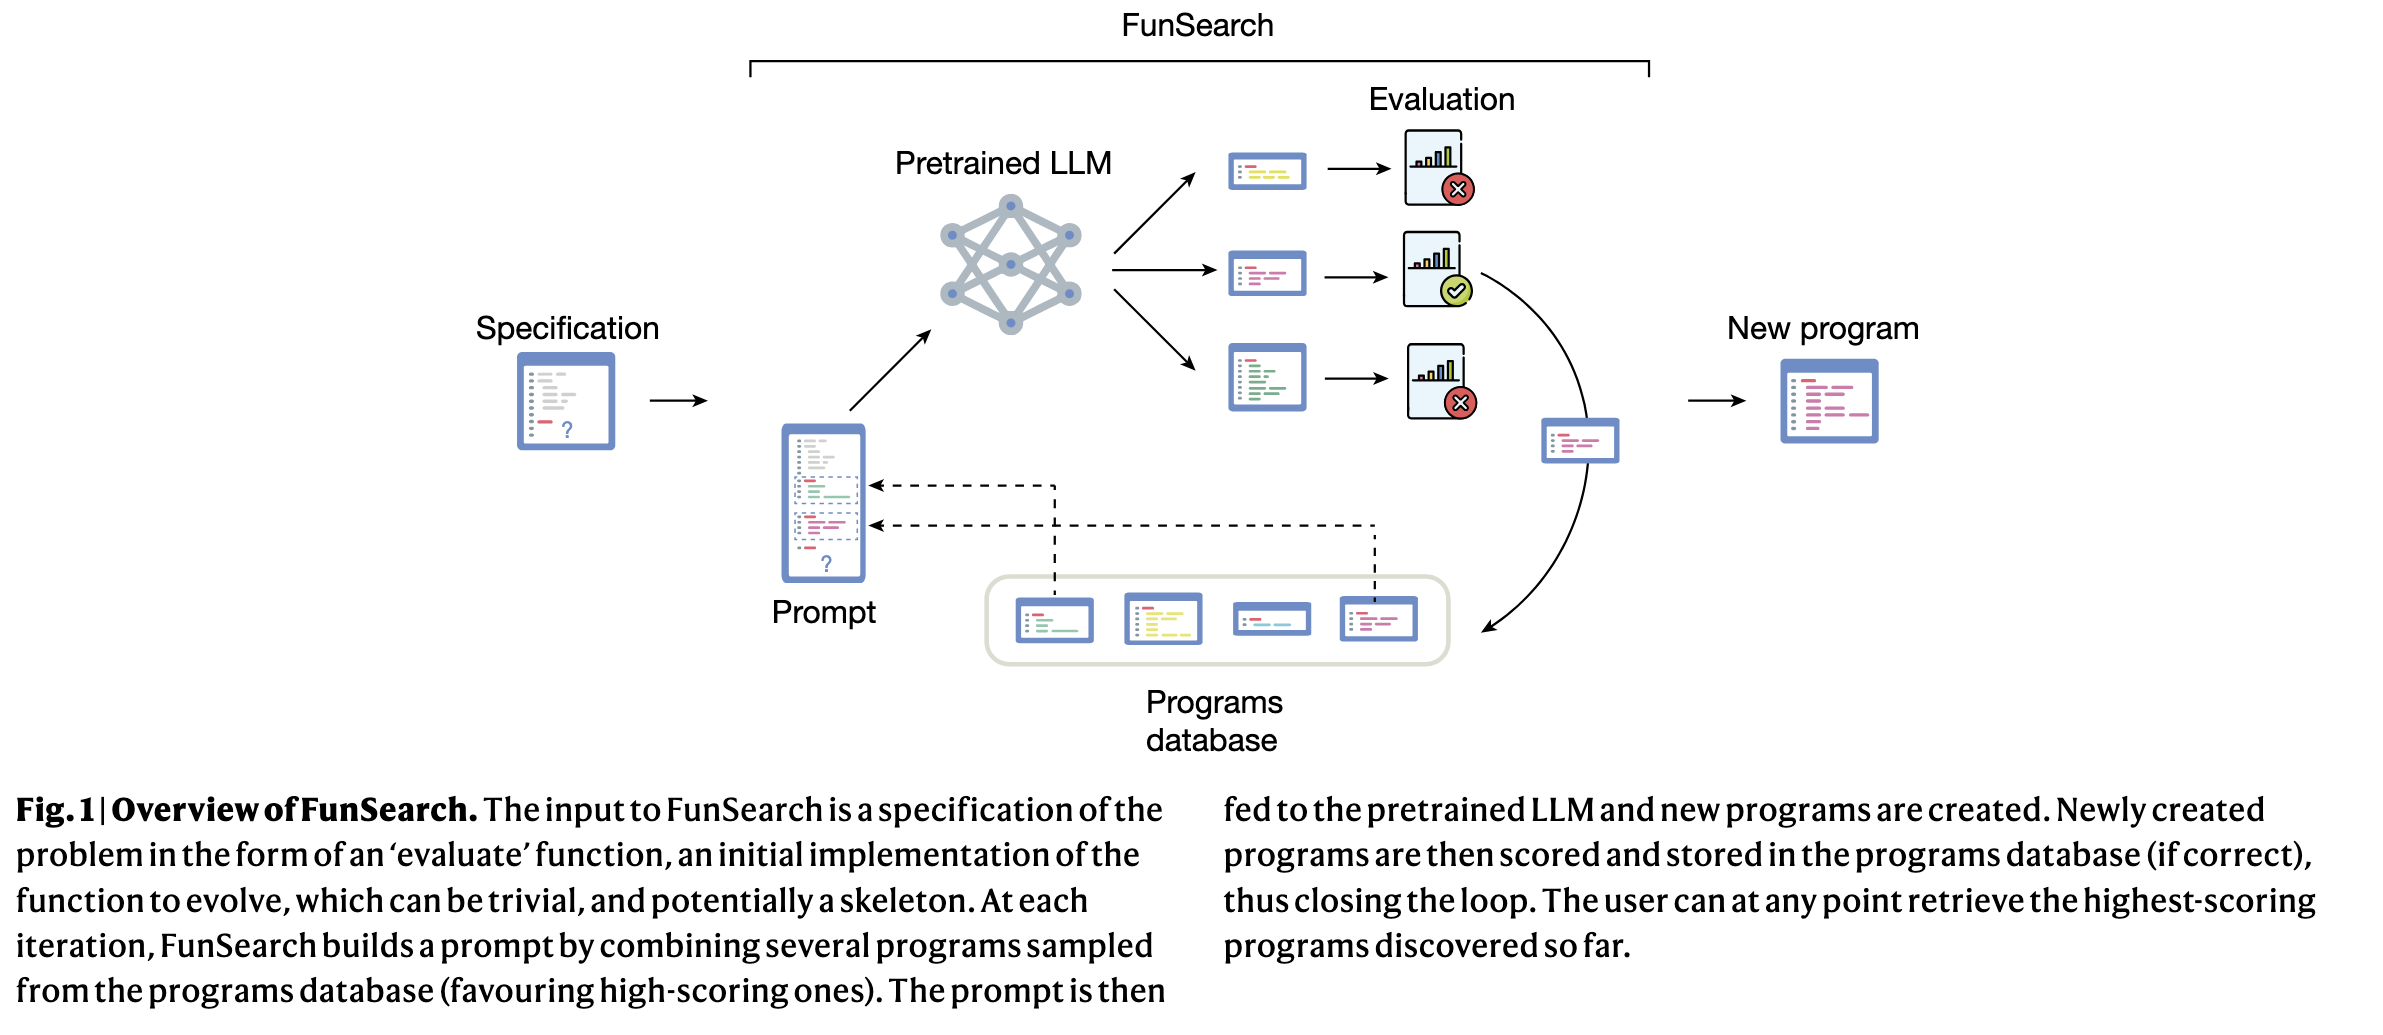

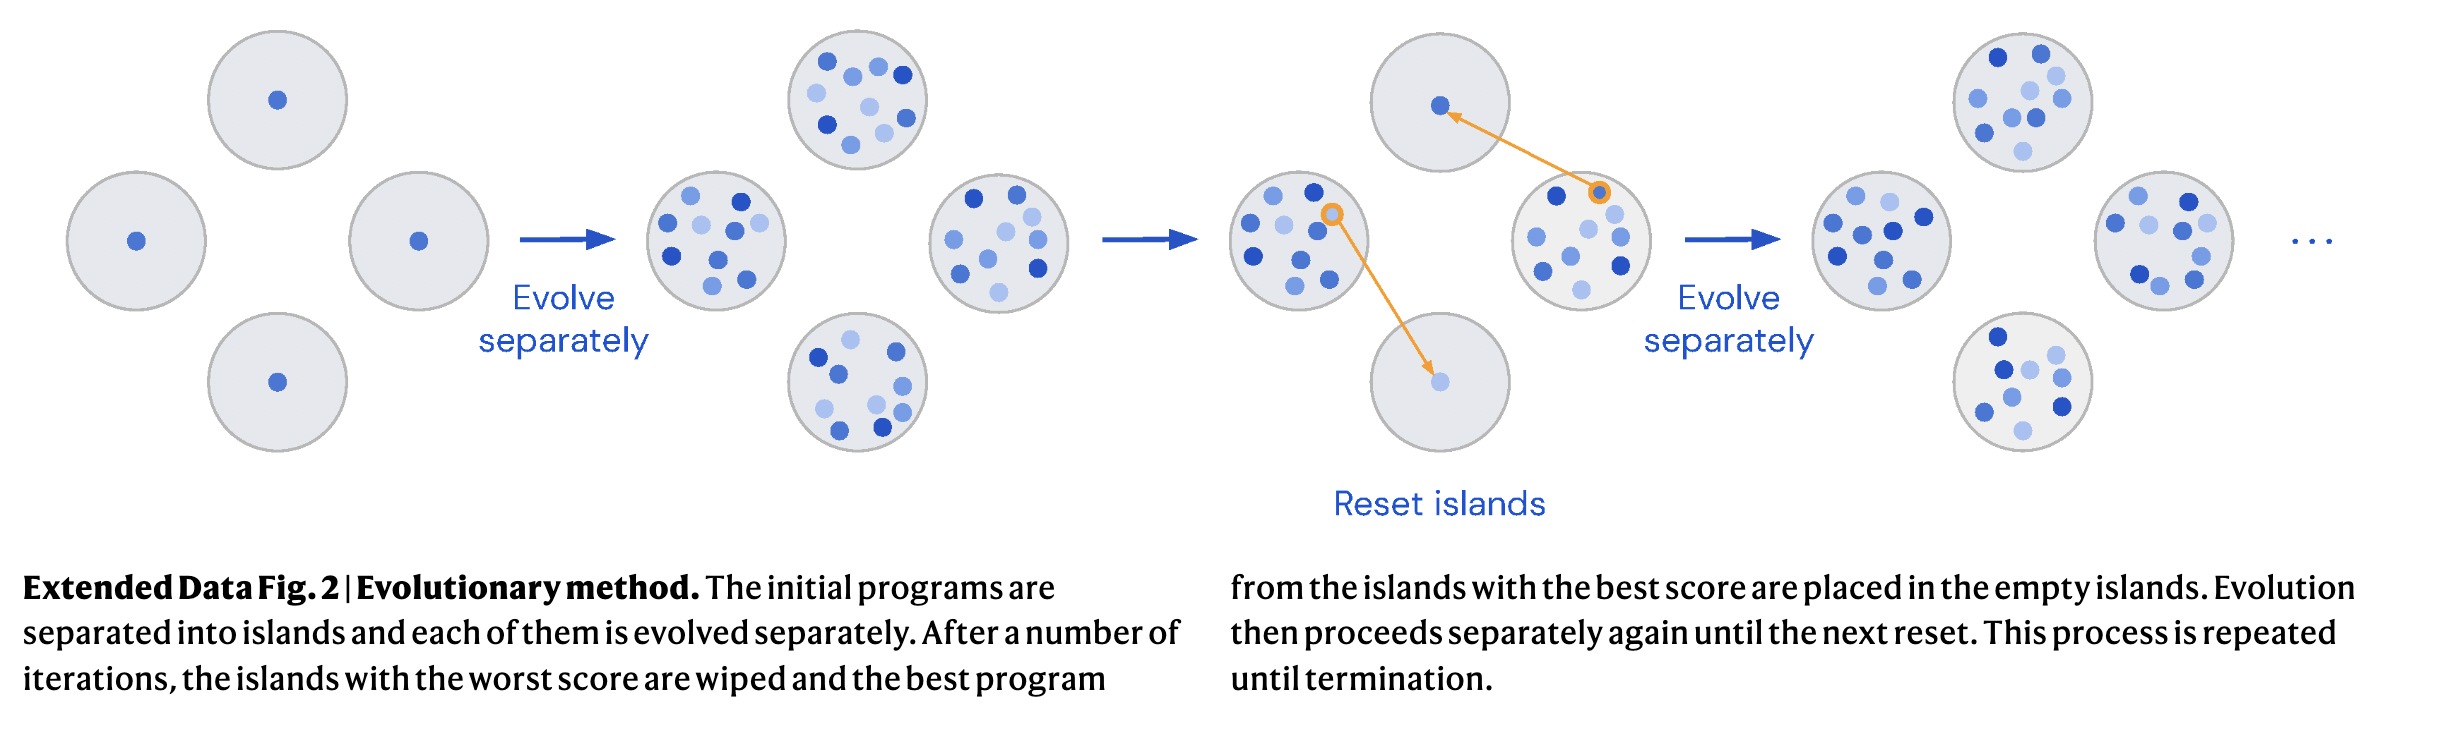

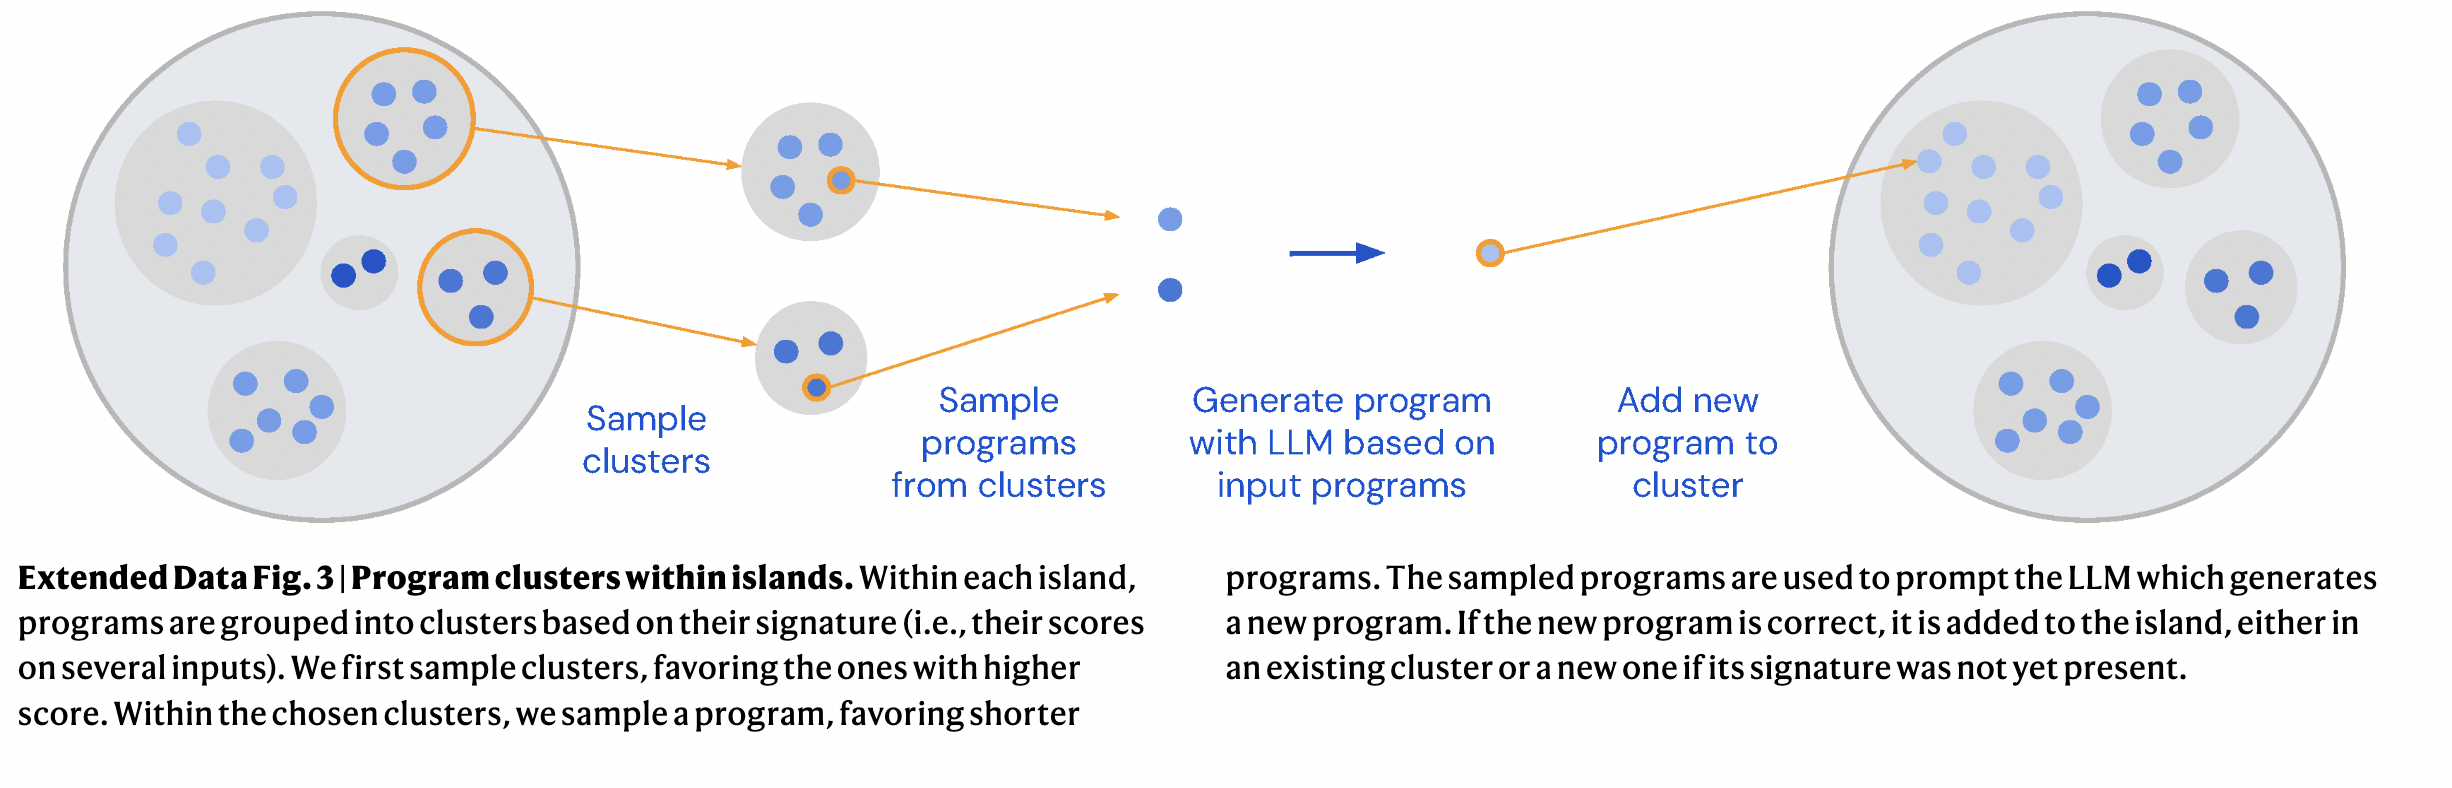


To simplify, and without delving into NP-problem theory, it's important to recall that certain problems are difficult to solve but easy to verify.

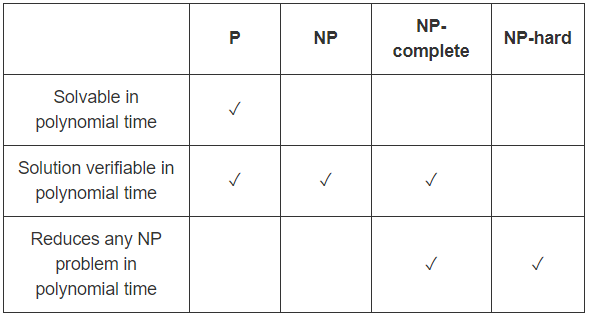

More precisely, FunSearch can (potentialy) be useful for problems with:

1. an efficient evaluator,
2. smooth or at least rich scoring feedback for iterative improvement,
3. prior problem information for a strong initial structure.

Examples of such problems considered in the article:

1. The “cap set” problem https://en.wikipedia.org/wiki/Cap_set.
2. “Online bin packing,” https://en.wikipedia.org/wiki/Bin_packing_problem.

# 3. Simple FunSearch-like example

The following code is for demonstration only, illustrating the concept rather than a final solution.
<font color='red'>**LLMs may not produce functional code.**</font>

For simplicity we use code from https://github.com/leocus/SimpleFunSearch/tree/main

We consider a very simple problem that we've used before:

  Given a positive integer n, find the largest subset A of {1,2,…,n} such that for any distinct a,b in A, neither a divides b nor b divides a.

In [ ]:
class Evaluator:
    """
    Abstract class for evaluators.
    This class also mantains the registry for the evaluators.
    """
    registry = {}

    def __init_subclass__(cls, **kwargs):
        """When initializing a subclass, add it to the registry."""
        Evaluator.registry[cls.__name__] = cls

    @classmethod
    def get_class(cls, name):
        return Evaluator.registry[name]

    def __call__(self, program):
        """Evaluate the program and return its loss."""
        return self.evaluate(program)

    def evaluate(self, program):
        """Evaluate the program and return its loss."""
        try:
            print(f"Testing {program}")
            exec(program, globals(), locals())
            heuristic = locals()['solution']
            return self._execute_and_return_loss(heuristic)
        except:
            # Malformed solution
            return float("inf")

    @abstractmethod
    def _execute_and_return_loss(self, heuristic):
        pass


class MyEvaluator(Evaluator):
    """
    Antichain-under-divisibility evaluator.

    Greedily builds a subset A ⊆ {1, …, n} using the provided heuristic to rank
    feasible candidates, where feasibility means: for all a ∈ A, neither a | x nor x | a.
    The final score (loss) is -|A|, i.e., the negative size of the selected set.

    Expected heuristic signature:
        solution(candidate, selected) -> numeric score
    (If the heuristic only accepts `candidate`, it is also supported.)
    """

    def __init__(self, n: int):
        self._n = n

    @staticmethod
    def _valid(selected, x: int) -> bool:
        for a in selected:
            if x % a == 0 or a % x == 0:
                return False
        return True

    def _execute_and_return_loss(self, heuristic):
        selected = []
        remaining = set(range(1, self._n + 1))

        while True:
            # Candidates that keep the antichain property if added
            feasible = [x for x in remaining if self._valid(selected, x)]
            if not feasible:
                break

            # Score feasible candidates with the heuristic
            try:
                scored = [(heuristic(x, selected), x) for x in feasible]
            except TypeError:
                # Fall back if the heuristic takes only the candidate
                scored = [(heuristic(x), x) for x in feasible]

            # Pick the candidate with the highest heuristic score
            _, best_x = max(scored, key=lambda t: t[0])
            selected.append(best_x)
            remaining.remove(best_x)

        # Loss is negative of the number of selected elements
        return -len(selected)

### Model

### EvolutionaryLoop

The original paper suggested the following:

1. We first *sample $k$ programs* from a single island in the programs database.
2.   Sampled programs are *sorted* according to their score.
3. A *version* is assigned to each program (‘v0’ for the lowest scoring program, ‘v1’ for the second lowest scoring
and so on).
4. These programs are then *combined into a single prompt*. In the prompt we append:


*   the version  as a suffix to the function name (e.g. ‘priority_v0’, ‘priority_v1’, ...)
*  the header of the function we wish to generate (e.g., ‘priority_vk’).

It was suggested to sample $k=2$ function:

> In practice, **we set k = 2**, as two functions lead to better results compared to just one, with diminishing returns beyond that. Constructing a prompt by combining several programs (as opposed to only one) enables the LLM to spot patterns across the different programs and generalize those.


For simplicity, the model below has **a single island**. In evolutionary algorithms, using multiple islands and starting points helps *to avoid local minima or find better ones*.





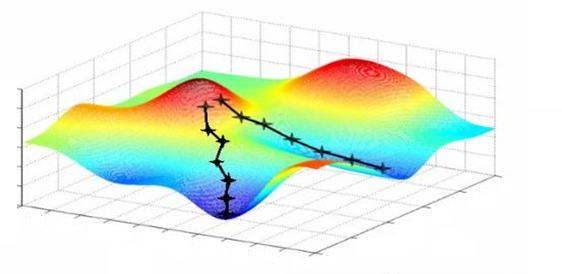

In [ ]:
class EvolutionaryLoop:
    def __init__(self, model, k, initial_solution, intype, outtype):
        """
        Initialize the evolutionary loop.
        This class tries to find agents that minimize a loss funciton.
        Params:
            model: an instance of Model
            k: the number of parameters to sample
            initial_solution: the initial solution
            intype: a string denoting the input type
            outtype: a string denoting the output type
        """
        self._model = model
        self._k = k
        self._pop = [initial_solution]
        self._fitnesses = []
        self._intype = intype
        self._outtype = outtype
        # Keep old populations to allow mu+lambda selection
        self._old_pop = []
        self._old_fit = []

    def ask(self):
        return self._pop

    def tell(self, fitnesses):
        # Order in ascending order
        fitnesses.extend(self._old_fit)
        self._pop.extend(self._old_pop)
        order = np.argsort(fitnesses)

        # Reorder population
        self._fitnesses = [fitnesses[i] for i in order]
        self._pop = [self._pop[i] for i in order]

        # Keep only the best ones in the old_pop (old population) - reduce memory consumption
        self._old_pop = [x for x in self._pop[:2]]
        self._old_fit = [x for x in self._fitnesses[:2]]

        # Generate new _pop - create the prompt
        prompt = ""
        for cnt, ind in enumerate(reversed(self._pop[:2])):
            prompt += f"```python\ndef solution_v{cnt}(x: {self._intype}) -> {self._outtype}:\n"
            for line in ind.split('\n')[1:]:
                prompt += line + '\n'
            prompt += "```\n"

        print("#"*80)
        print("#" + "prompt".center(78) + "#")
        print("#"*80)
        print("Prompt:", prompt)

        # Generate new _pop - sample new individuals
        self._pop = [self._model(prompt) for i in range(self._k)]
        print("Uncleaned:", self._pop)
        self._pop = [self._clean_solution(x) for x in self._pop]
        print("Cleaned:", self._pop)


    def get_best(self):
        # Population is sorted - return the last individual
        return self._pop[-1]

    def _clean_solution(self, x):
        """
        Retrieves only the code from a reply and refactors the functions' name.
        """
        try:
            candidate_string = x.split('```')[1]
            candidate_string = candidate_string.replace('python', '', 1)
            candidate_string = candidate_string.replace('\\n', '\n')

            # Refactor the name in case we have both a single starting solution (first gen) and two starting solutions.
            candidate_string = re.sub('solution_v.', 'solution', candidate_string)

            while (candidate_string[0] == '\n'):
                candidate_string = candidate_string[1:]

            while (candidate_string[-2:] == '\n\n'):
                candidate_string = candidate_string[:-1]
        except:
            candidate_string = f"def solution(x: {self._intype}) -> {self._outtype}:\n\treturn 0"
        return candidate_string

### Model parameters

We use the following prompt


>  'You are an AI coding assistant. Your goal is to improve the given functions in order to make them improve their correctness and efficiency. It is very important that you name the functions in sequential order, e.g., if the last solution was `solution_v0`, you should provide `solution_v1`, and if the last was `solution_v1`, you should provide `solution_v2`. Always return a function that is different from the previous ones.'

The parameters to change:

*   EVO_LOOP_GENS (Number of Generations)
*   EVO_LOOP_K (How many programs to generate on each step)

Remember, tokens cost money. <font color='red'>**Use timeout in communications and be careful to avoid deadlocks.**</font>


In [ ]:
# Which LLM to use
# For more models, see https://docs.nebius.com/studio/inference/models/
MODEL_URL = "https://api.studio.nebius.ai/v1/"
MODEL_NAME =  "meta-llama/Meta-Llama-3.1-70B-Instruct"
MODEL_KEY = "NEBIUS_API_KEY"


SYSTEM_PROMT = 'You are an AI coding assistant. Your goal is to improve the given functions in order to make them improve their correctness and efficiency. It is very important that you name the functions in sequential order, e.g., if the last solution was `solution_v0`, you should provide `solution_v1`, and if the last was `solution_v1`, you should provide `solution_v2`. Always return a function that is different from the previous ones.'

EVO_LOOP_K = 5 # 10
EVO_LOOP_GENS = 5 # 10
MAX_GEN = 20

INITIAL_SOLUTION = """
def solution(candidate, selected=None):
    if selected is None:
        selected = []

    for a in selected:
        if candidate % a == 0 or a % candidate == 0:
            return float("-inf")
    return 1
"""

INTYPE = 'int'
OUTTYPE = 'float'

EVALUATOR_PARAMS = {
    'name': 'MyEvaluator',
    'kwargs': 10
}



In [ ]:
def init_model(MODEL_URL, MODEL_NAME, MODEL_KEY, SYSTEM_PROMT, EVO_LOOP_K,
        INITIAL_SOLUTION, INTYPE, OUTTYPE, EVALUATOR_PARAMS):
    # Init the model
    model = Model(
        MODEL_URL,
        MODEL_NAME,
        MODEL_KEY,
        SYSTEM_PROMT,
    )

    # Init the EA
    ea = EvolutionaryLoop(
        model,
        EVO_LOOP_K,
        INITIAL_SOLUTION,
        INTYPE,
        OUTTYPE
    )

    # Init the evaluator
    evaluator = Evaluator.get_class(EVALUATOR_PARAMS['name'])(
        EVALUATOR_PARAMS['kwargs']
    )

    return model, ea, evaluator

model, ea, evaluator = init_model(MODEL_URL, MODEL_NAME, MODEL_KEY, SYSTEM_PROMT, EVO_LOOP_K,
        INITIAL_SOLUTION, INTYPE, OUTTYPE, EVALUATOR_PARAMS)

Running "Simple FunSearch"

In [ ]:
def solve_problem(ea, evaluator, EVO_LOOP_GENS):
    best = None
    best_fit = float("inf")

    num_gen = 0

    # Evolve the functions
    for generation in range(EVO_LOOP_GENS): # fix number of generations
        # Generate new solutions
        solutions = ea.ask()
        fitnesses = []
        for idx, solution in enumerate(solutions):
            fitnesses.append(evaluator(solution))
        print(fitnesses)

        #
        ea.tell(fitnesses)

        # Find best solutions
        argmin = np.argmin(fitnesses)
        if fitnesses[argmin] < best_fit:
            best_fit = fitnesses[argmin]
            best = solutions[argmin]

        print(f"Generation {generation}")
        for f in (np.min, np.mean, np.std, np.max):
            print(f"\t{f.__name__}: {f(fitnesses)}")
        print(f"Best so far: {best_fit}")

        # use timeouts - better safe, then sorry
        num_gen += 1
        if num_gen > MAX_GEN:
            break

solve_problem(ea, evaluator, 2)

Testing 
def solution(candidate, selected=None):
    if selected is None:
        selected = []

    for a in selected:
        if candidate % a == 0 or a % candidate == 0:
            return float("-inf")
    return 1

[-1]
################################################################################
#                                    prompt                                    #
################################################################################
Prompt: ```python
def solution_v0(x: int) -> float:
def solution(candidate, selected=None):
    if selected is None:
        selected = []

    for a in selected:
        if candidate % a == 0 or a % candidate == 0:
            return float("-inf")
    return 1

```



KeyboardInterrupt: 

# Prompt Engineering for FunSearch

As it was noted in the paper: if available, the user can optionally **provide extra known information** about the problem at hand, in the form of docstrings, relevant primitive functions or import packages. Better prompts may lead to better results.

In [ ]:
SYSTEM_PROMT = """
You are an AI coding assistant. Your goal is to improve
the given functions in order to increase their correctness and efficiency.

The task is: given a positive integer n, find the largest subset A of {1,2,…,n}
such that for any distinct a, b in A, neither a divides b nor b divides a.
In other words, A must form a maximum-size antichain under divisibility.

It is very important that you name the functions in sequential order,
e.g., if the last solution was `solution_v0`, you should provide `solution_v1`,
and if the last was `solution_v1`, you should provide `solution_v2`.
Always return a function that is different from the previous ones.
"""

EVO_LOOP_K = 2
EVO_LOOP_GENS = 2

In [ ]:
model, ea, evaluator = init_model(MODEL_URL, MODEL_NAME, MODEL_KEY, SYSTEM_PROMT, EVO_LOOP_K,
        INITIAL_SOLUTION, INTYPE, OUTTYPE, EVALUATOR_PARAMS)

In [ ]:
solve_problem(ea, evaluator, EVO_LOOP_GENS)

Testing 
def solution(candidate, selected=None):
    if selected is None:
        selected = []

    for a in selected:
        if candidate % a == 0 or a % candidate == 0:
            return float("-inf")
    return 1

[-1]
################################################################################
#                                    prompt                                    #
################################################################################
Prompt: ```python
def solution_v0(x: int) -> float:
def solution(candidate, selected=None):
    if selected is None:
        selected = []

    for a in selected:
        if candidate % a == 0 or a % candidate == 0:
            return float("-inf")
    return 1

```

Uncleaned: ['Here\'s an improved version of the function, which I\'ll name `solution_v1`. This function uses a more efficient approach to solve the problem. Instead of iterating over all possible subsets of the set {1, 2, ..., n}, we use a greedy strategy to selec

In mathematics, achieving the correct answer is the primary goal. From a conceptual standpoint, the methods above represent distinct approaches:

*    **Prompt engineering** aims to elicit solutions from an LLM's existing knowledge.
*   In contrast, **evolutionary strategies** adopt an iterative approach, wherein random perturbations are introduced and evaluated, with the objective of incrementally progressing toward a more optimal solution.



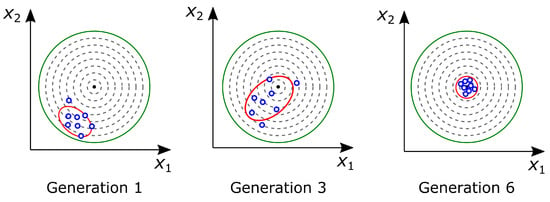

Evolutionary strategies are **highly parallelizable**, which is a major benefit. However, they come with significant drawbacks:

*   they can be extremely *slow*,
*   they *struggle with high-dimensional problems*,
*   they may *demand substantial computational resources and time*.